# FEEMS Shore Power Connection Example

This notebook demonstrates how to build an electric power system with a shore power connection.

Shore power allows ships to connect to land-based electrical power while docked, reducing emissions and fuel consumption by shutting down onboard generators.

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from feems.components_model import Engine, Genset
from feems.components_model.component_electric import (
    ElectricComponent,
    ElectricMachine,
    ShorePowerConnection,
    ShorePowerConnectionSystem,
)
from feems.system_model import ElectricPowerSystem, IntegrationMethod
from feems.types_for_feems import (
    Power_kW,
    Speed_rpm,
    SwbId,
    TypeComponent,
    TypePower,
)

## 2. Create a Simple Shore Power Connection

The simplest shore power connection requires just a name, rated power, and switchboard ID.

In [2]:
# Create a basic shore power connection
shore_power = ShorePowerConnection(
    name="Shore Power",
    rated_power=Power_kW(1000),  # 1 MW shore connection
    switchboard_id=SwbId(1)
)

print(f"Component type: {shore_power.type}")
print(f"Power type: {shore_power.power_type}")
print(f"Rated power: {shore_power.rated_power} kW")
print(f"Switchboard ID: {shore_power.switchboard_id}")

Component type: TypeComponent.SHORE_POWER
Power type: TypePower.POWER_SOURCE
Rated power: 1000 kW
Switchboard ID: 1


## 3. Create a Shore Power System with Converter

In real installations, shore power often includes a converter to match the ship's electrical system (voltage/frequency conversion).

In [3]:
# Create shore power connection
shore_power_connection = ShorePowerConnection(
    name="Shore Power Connection",
    rated_power=Power_kW(1200),
    switchboard_id=SwbId(1)
)

# Create a converter/transformer for the shore connection
# Efficiency curve: [load, efficiency]
converter = ElectricComponent(
    type_=TypeComponent.POWER_CONVERTER,
    name="Shore Power Converter",
    rated_power=Power_kW(1200),
    power_type=TypePower.POWER_TRANSMISSION,
    switchboard_id=SwbId(1),
    eff_curve=np.array([[0.25, 0.5, 0.75, 1.0], [0.96, 0.97, 0.98, 0.98]]).T
)

# Create shore power system (connection + converter)
shore_power_system = ShorePowerConnectionSystem(
    name="Shore Power System",
    shore_power_connection=shore_power_connection,
    converter=converter,
    switchboard_id=SwbId(1)
)

print(f"Shore power system created: {shore_power_system.name}")
print(f"Rated power: {shore_power_system.rated_power} kW")

Shore power system created: Shore Power System
Rated power: 1200 kW


## 4. Build a Complete Electric Power System

Now let's create a complete system with:
- Shore power connection
- Two backup gensets
- Auxiliary loads

This represents a typical docked vessel scenario.

In [4]:
# Create auxiliary engines
aux_engine_1 = Engine(
    type_=TypeComponent.AUXILIARY_ENGINE,
    name="Auxiliary engine 1",
    rated_power=Power_kW(500),
    rated_speed=Speed_rpm(1500),
    bsfc_curve=np.array([[0.25, 0.5, 0.75, 1.0], [280.0, 220.0, 200.0, 210.0]]).T
)

aux_engine_2 = Engine(
    type_=TypeComponent.AUXILIARY_ENGINE,
    name="Auxiliary engine 2",
    rated_power=Power_kW(500),
    rated_speed=Speed_rpm(1500),
    bsfc_curve=np.array([[0.25, 0.5, 0.75, 1.0], [280.0, 220.0, 200.0, 210.0]]).T
)

# Create generators
generator_1 = ElectricMachine(
    type_=TypeComponent.GENERATOR,
    name="Generator 1",
    rated_power=Power_kW(475),
    rated_speed=Speed_rpm(1500),
    power_type=TypePower.POWER_SOURCE,
    switchboard_id=SwbId(1),
    eff_curve=np.array([[0.25, 0.5, 0.75, 1.0], [0.88, 0.92, 0.94, 0.95]]).T
)

generator_2 = ElectricMachine(
    type_=TypeComponent.GENERATOR,
    name="Generator 2",
    rated_power=Power_kW(475),
    rated_speed=Speed_rpm(1500),
    power_type=TypePower.POWER_SOURCE,
    switchboard_id=SwbId(1),
    eff_curve=np.array([[0.25, 0.5, 0.75, 1.0], [0.88, 0.92, 0.94, 0.95]]).T
)

# Create gensets
genset_1 = Genset(
    name="Genset 1",
    aux_engine=aux_engine_1,
    generator=generator_1
)

genset_2 = Genset(
    name="Genset 2",
    aux_engine=aux_engine_2,
    generator=generator_2
)

# Create auxiliary load
aux_load = ElectricComponent(
    type_=TypeComponent.OTHER_LOAD,
    name="Auxiliary Load",
    rated_power=Power_kW(1000),
    power_type=TypePower.POWER_CONSUMER,
    switchboard_id=SwbId(1)
)

print("Components created successfully:")
print(f"- Shore Power: {shore_power_system.rated_power} kW")
print(f"- Genset 1: {genset_1.rated_power} kW")
print(f"- Genset 2: {genset_2.rated_power} kW")
print(f"- Auxiliary Load: {aux_load.rated_power} kW")

Components created successfully:
- Shore Power: 1200 kW
- Genset 1: 475 kW
- Genset 2: 475 kW
- Auxiliary Load: 1000 kW


## 5. Create the Electric Power System

In [5]:
# Create the electric power system
power_plant_components = [
    shore_power_system,  # Shore power
    genset_1,            # Backup genset 1
    genset_2,            # Backup genset 2
    aux_load             # Hotel loads
]

electric_power_system = ElectricPowerSystem(
    name="Ship Power System with Shore Connection",
    power_plant_components=power_plant_components,
    bus_tie_connections=[]  # Single bus system
)

print(f"\nPower system created: {electric_power_system.name}")
print(f"Number of power sources: {electric_power_system.no_power_sources}")
print(f"Number of loads: {electric_power_system.no_other_load}")
print(f"\nPower sources:")
for source in electric_power_system.power_sources:
    print(f"  - {source.name}: {source.rated_power} kW")


Power system created: Ship Power System with Shore Connection
Number of power sources: 3
Number of loads: 1

Power sources:
  - Shore Power System: 1200 kW
  - Genset 1: 475 kW
  - Genset 2: 475 kW


## 6. Scenario 1: Shore Power Only (Typical Docked Operation)

When docked with shore power available, gensets are turned off to save fuel and reduce emissions.

In [6]:
# Simulation parameters
n_points = 100
time_step_s = 60  # 1 minute intervals

# Generate variable auxiliary load (hotel loads while docked)
# Base load + some variation for HVAC, lighting, galley equipment, etc.
base_load = 200  # kW
load_variation = 100  # kW
auxiliary_load_profile = base_load + load_variation * np.random.random(n_points)

# Set the load on the auxiliary load component
electric_power_system.set_power_input_from_power_output_by_switchboard_id_type_name(
    power_output=auxiliary_load_profile,
    switchboard_id=1,
    type_=TypePower.POWER_CONSUMER,
    name="Auxiliary Load"
)

# Power source status (on/off) for shore power operation
# Shore power: ON
shore_power_status = np.ones([n_points, 1]).astype(bool)
# Genset 1: OFF
genset_1_status = np.zeros([n_points, 1]).astype(bool)
# Genset 2: OFF
genset_2_status = np.zeros([n_points, 1]).astype(bool)

# Combine status for all power sources [shore, genset1, genset2]
all_sources_status = np.hstack([shore_power_status, genset_1_status, genset_2_status])

electric_power_system.set_status_by_switchboard_id_power_type(
    switchboard_id=1,
    power_type=TypePower.POWER_SOURCE,
    status=all_sources_status
)

# Set load sharing mode (equal sharing)
load_sharing = np.zeros([n_points, 3])  # All equal sharing
electric_power_system.set_load_sharing_mode_power_sources_by_switchboard_id_power_type(
    switchboard_id=1,
    power_type=TypePower.POWER_SOURCE,
    load_sharing_mode=load_sharing
)

# Set time intervals
electric_power_system.set_time_interval(time_step_s, integration_method=IntegrationMethod.simpson)

# Perform power balance calculation
electric_power_system.do_power_balance_calculation()

print("\nScenario 1: Shore Power Only")
print(f"Average auxiliary load: {np.mean(auxiliary_load_profile):.1f} kW")
print(f"Peak auxiliary load: {np.max(auxiliary_load_profile):.1f} kW")


Scenario 1: Shore Power Only
Average auxiliary load: 246.2 kW
Peak auxiliary load: 298.7 kW


### Visualize Power Balance

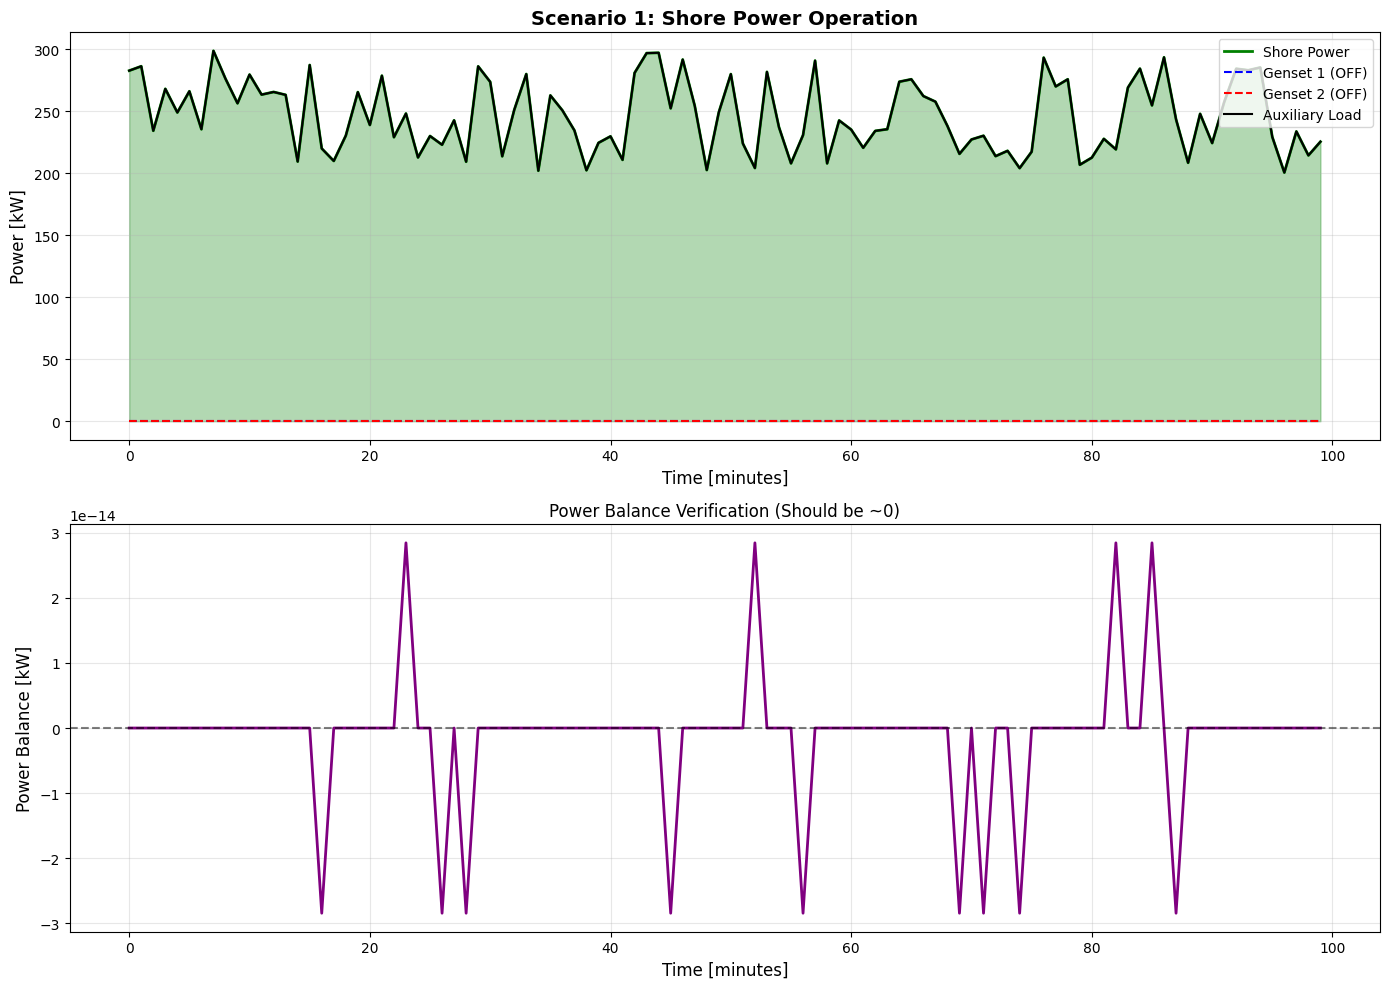


Power balance error: 2.84e-14 kW (should be near zero)


In [7]:
# Extract power data
shore_power_output = electric_power_system.power_sources[0].power_output
genset_1_output = electric_power_system.power_sources[1].power_output
genset_2_output = electric_power_system.power_sources[2].power_output
aux_load_input = electric_power_system.other_load[0].power_input

# Calculate power balance
power_balance = shore_power_output + genset_1_output + genset_2_output - aux_load_input

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Power flow
time_minutes = np.arange(n_points)
ax1.plot(time_minutes, shore_power_output, 'g-', linewidth=2, label='Shore Power')
ax1.plot(time_minutes, genset_1_output, 'b--', label='Genset 1 (OFF)')
ax1.plot(time_minutes, genset_2_output, 'r--', label='Genset 2 (OFF)')
ax1.plot(time_minutes, aux_load_input, 'k-', linewidth=1.5, label='Auxiliary Load')
ax1.fill_between(time_minutes, shore_power_output, alpha=0.3, color='green')
ax1.set_ylabel('Power [kW]', fontsize=12)
ax1.set_xlabel('Time [minutes]', fontsize=12)
ax1.set_title('Scenario 1: Shore Power Operation', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Power balance check
ax2.plot(time_minutes, power_balance, 'purple', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_ylabel('Power Balance [kW]', fontsize=12)
ax2.set_xlabel('Time [minutes]', fontsize=12)
ax2.set_title('Power Balance Verification (Should be ~0)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPower balance error: {np.max(np.abs(power_balance)):.2e} kW (should be near zero)")

### Calculate Fuel Consumption and Emissions

In [8]:
# Get fuel consumption and emissions results
result_shore_power = electric_power_system.get_fuel_energy_consumption_running_time()

print("\n" + "="*60)
print("SCENARIO 1: SHORE POWER ONLY - RESULTS")
print("="*60)
print(f"\nDuration: {result_shore_power.duration_s / 60:.1f} minutes")
print(f"\nTotal fuel consumption: {result_shore_power.multi_fuel_consumption_total_kg.fuels[0].mass_or_mass_fraction:.3f} kg")
print(f"Total CO2 emissions: {result_shore_power.co2_emission_total_kg.tank_to_wake_kg_or_gco2eq_per_gfuel:.3f} kg")
print(f"\nGenset running hours:")
print(f"  Total: {result_shore_power.running_hours_genset_total_hr:.3f} hours")
print(f"\nEnergy consumption:")
print(f"  Auxiliary loads: {result_shore_power.energy_consumption_auxiliary_total_mj:.2f} MJ")

if len(result_shore_power.total_emission_kg) > 0:
    print(f"\nNOx emissions: {list(result_shore_power.total_emission_kg.values())[0]:.3f} kg")

print("\n" + "-"*60)
print("KEY OBSERVATION: With shore power, fuel consumption is ZERO!")
print("-"*60)

2026-02-11 12:22:56,488 - feems.components_model.utility - WARNING - The integration method is not 'sum_with_time' while the data to integrate has only one point. 'sum_with_time' will be used for integration to avoid getting 0 value.



SCENARIO 1: SHORE POWER ONLY - RESULTS

Duration: 100.0 minutes

Total fuel consumption: 0.000 kg
Total CO2 emissions: 0.000 kg

Genset running hours:
  Total: 0.000 hours

Energy consumption:
  Auxiliary loads: 1469.55 MJ

NOx emissions: 0.000 kg

------------------------------------------------------------
KEY OBSERVATION: With shore power, fuel consumption is ZERO!
------------------------------------------------------------


## 7. Scenario 2: Genset Operation (Shore Power Unavailable)

Now let's simulate the same load profile but with gensets running instead of shore power.

In [9]:
# Power source status for genset operation
# Shore power: OFF (not available)
shore_power_status = np.zeros([n_points, 1]).astype(bool)
# Genset 1: ON
genset_1_status = np.ones([n_points, 1]).astype(bool)
# Genset 2: OFF (standby)
genset_2_status = np.zeros([n_points, 1]).astype(bool)

# Combine status for all power sources
all_sources_status = np.hstack([shore_power_status, genset_1_status, genset_2_status])

electric_power_system.set_status_by_switchboard_id_power_type(
    switchboard_id=1,
    power_type=TypePower.POWER_SOURCE,
    status=all_sources_status
)

# Perform power balance calculation
electric_power_system.do_power_balance_calculation()

print("\nScenario 2: Genset Operation (No Shore Power)")


Scenario 2: Genset Operation (No Shore Power)


### Visualize Genset Operation

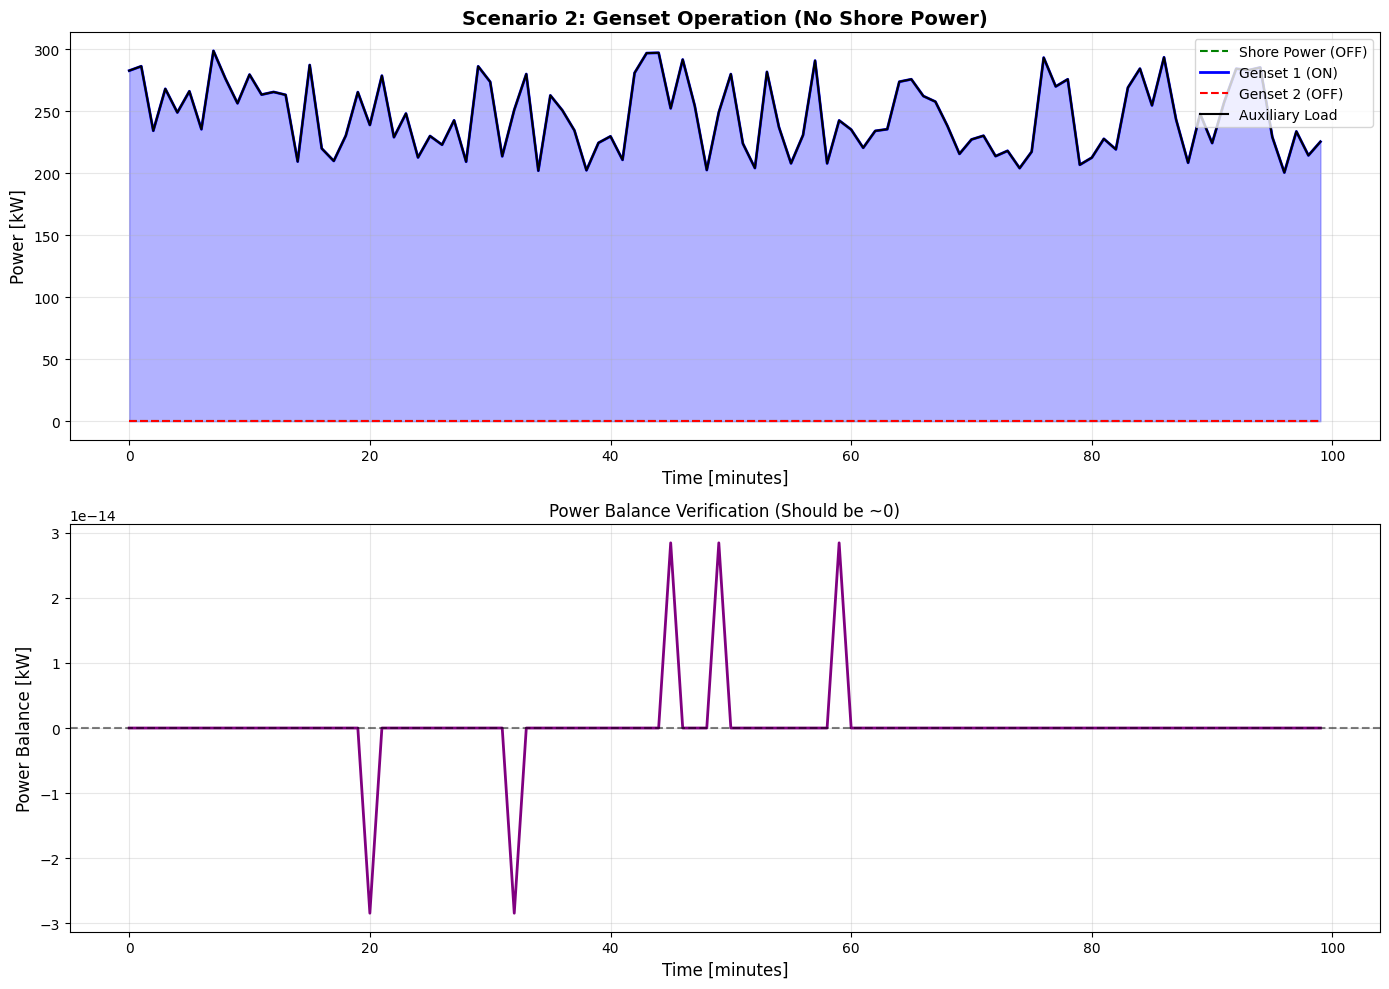

In [10]:
# Extract power data
shore_power_output = electric_power_system.power_sources[0].power_output
genset_1_output = electric_power_system.power_sources[1].power_output
genset_2_output = electric_power_system.power_sources[2].power_output
aux_load_input = electric_power_system.other_load[0].power_input

# Calculate power balance
power_balance = shore_power_output + genset_1_output + genset_2_output - aux_load_input

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Power flow
ax1.plot(time_minutes, shore_power_output, 'g--', label='Shore Power (OFF)')
ax1.plot(time_minutes, genset_1_output, 'b-', linewidth=2, label='Genset 1 (ON)')
ax1.plot(time_minutes, genset_2_output, 'r--', label='Genset 2 (OFF)')
ax1.plot(time_minutes, aux_load_input, 'k-', linewidth=1.5, label='Auxiliary Load')
ax1.fill_between(time_minutes, genset_1_output, alpha=0.3, color='blue')
ax1.set_ylabel('Power [kW]', fontsize=12)
ax1.set_xlabel('Time [minutes]', fontsize=12)
ax1.set_title('Scenario 2: Genset Operation (No Shore Power)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Power balance check
ax2.plot(time_minutes, power_balance, 'purple', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_ylabel('Power Balance [kW]', fontsize=12)
ax2.set_xlabel('Time [minutes]', fontsize=12)
ax2.set_title('Power Balance Verification (Should be ~0)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Calculate Fuel Consumption and Compare

In [11]:
# Get fuel consumption and emissions results
result_genset = electric_power_system.get_fuel_energy_consumption_running_time()

print("\n" + "="*60)
print("SCENARIO 2: GENSET OPERATION - RESULTS")
print("="*60)
print(f"\nDuration: {result_genset.duration_s / 60:.1f} minutes")
print(f"\nTotal fuel consumption: {result_genset.multi_fuel_consumption_total_kg.fuels[0].mass_or_mass_fraction:.3f} kg")
print(f"Total CO2 emissions: {result_genset.co2_emission_total_kg.tank_to_wake_kg_or_gco2eq_per_gfuel:.3f} kg")
print(f"\nGenset running hours:")
print(f"  Total: {result_genset.running_hours_genset_total_hr:.3f} hours")
print(f"\nEnergy consumption:")
print(f"  Auxiliary loads: {result_genset.energy_consumption_auxiliary_total_mj:.2f} MJ")

if len(result_genset.total_emission_kg) > 0:
    print(f"\nNOx emissions: {list(result_genset.total_emission_kg.values())[0]:.3f} kg")

# Comparison
print("\n" + "="*60)
print("SHORE POWER vs GENSET COMPARISON")
print("="*60)

fuel_saved = result_genset.multi_fuel_consumption_total_kg.fuels[0].mass_or_mass_fraction - \
             result_shore_power.multi_fuel_consumption_total_kg.fuels[0].mass_or_mass_fraction

co2_saved = result_genset.co2_emission_total_kg.tank_to_wake_kg_or_gco2eq_per_gfuel - \
            result_shore_power.co2_emission_total_kg.tank_to_wake_kg_or_gco2eq_per_gfuel

print(f"\nFuel savings with shore power: {fuel_saved:.3f} kg")
print(f"  Percentage: 100%")
print(f"\nCO2 emission reduction: {co2_saved:.3f} kg")
print(f"  Percentage: 100%")

if len(result_genset.total_emission_kg) > 0:
    nox_saved = list(result_genset.total_emission_kg.values())[0] - \
                list(result_shore_power.total_emission_kg.values())[0]
    print(f"\nNOx emission reduction: {nox_saved:.3f} kg")
    print(f"  Percentage: 100%")

print("\n" + "="*60)
print("ENVIRONMENTAL IMPACT")
print("="*60)
print(f"\nFor {result_genset.duration_s / 3600:.2f} hours of operation:")
print(f"  - Fuel saved: {fuel_saved:.2f} kg")
print(f"  - CO2 avoided: {co2_saved:.2f} kg")
print(f"\nExtrapolated to 24 hours:")
hours_factor = 24 / (result_genset.duration_s / 3600)
print(f"  - Daily fuel savings: {fuel_saved * hours_factor:.1f} kg")
print(f"  - Daily CO2 reduction: {co2_saved * hours_factor:.1f} kg")
print(f"\nThis demonstrates the significant environmental benefit of shore power!")

2026-02-11 12:22:56,615 - feems.components_model.utility - WARNING - The integration method is not 'sum_with_time' while the data to integrate has only one point. 'sum_with_time' will be used for integration to avoid getting 0 value.



SCENARIO 2: GENSET OPERATION - RESULTS

Duration: 100.0 minutes

Total fuel consumption: 95.333 kg
Total CO2 emissions: 305.637 kg

Genset running hours:
  Total: 1.667 hours

Energy consumption:
  Auxiliary loads: 1469.55 MJ

NOx emissions: 3.622 kg

SHORE POWER vs GENSET COMPARISON

Fuel savings with shore power: 95.333 kg
  Percentage: 100%

CO2 emission reduction: 305.637 kg
  Percentage: 100%

NOx emission reduction: 3.622 kg
  Percentage: 100%

ENVIRONMENTAL IMPACT

For 1.67 hours of operation:
  - Fuel saved: 95.33 kg
  - CO2 avoided: 305.64 kg

Extrapolated to 24 hours:
  - Daily fuel savings: 1372.8 kg
  - Daily CO2 reduction: 4401.2 kg

This demonstrates the significant environmental benefit of shore power!


## 8. Scenario 3: Transition from Shore to Genset

This scenario demonstrates a ship disconnecting from shore power and starting gensets before departure.

In [12]:
# Create transition scenario
# First 60% on shore power, then switch to genset
transition_point = int(n_points * 0.6)

# Shore power: ON for first 60%, then OFF
shore_power_status = np.ones([n_points, 1]).astype(bool)
shore_power_status[transition_point:] = False

# Genset 1: OFF for first 60%, then ON
genset_1_status = np.zeros([n_points, 1]).astype(bool)
genset_1_status[transition_point:] = True

# Genset 2: Always OFF (standby)
genset_2_status = np.zeros([n_points, 1]).astype(bool)

# Combine status
all_sources_status = np.hstack([shore_power_status, genset_1_status, genset_2_status])

electric_power_system.set_status_by_switchboard_id_power_type(
    switchboard_id=1,
    power_type=TypePower.POWER_SOURCE,
    status=all_sources_status
)

# Perform power balance calculation
electric_power_system.do_power_balance_calculation()

print("\nScenario 3: Transition from Shore Power to Genset")
print(f"Transition point: {transition_point} minutes")


Scenario 3: Transition from Shore Power to Genset
Transition point: 60 minutes


### Visualize Transition

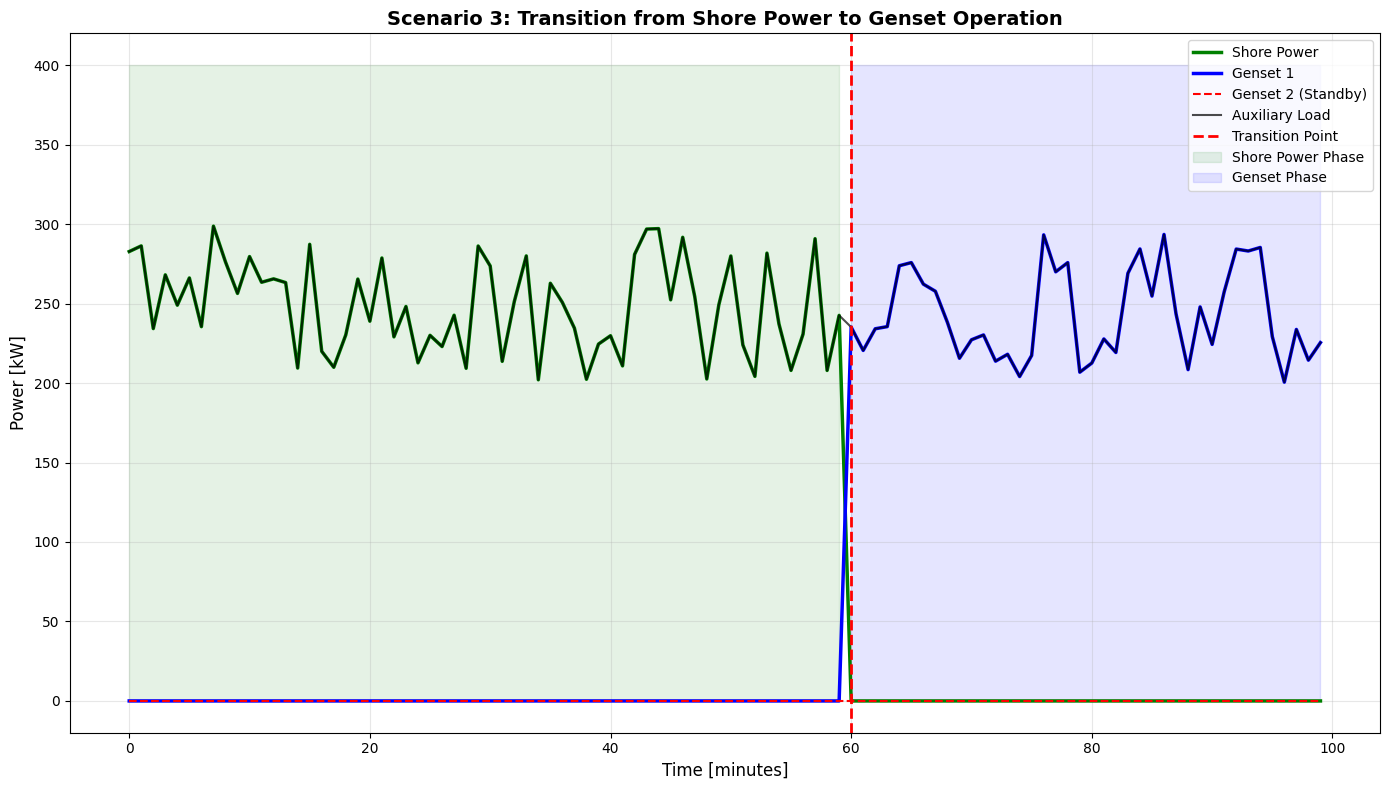

In [13]:
# Extract power data
shore_power_output = electric_power_system.power_sources[0].power_output
genset_1_output = electric_power_system.power_sources[1].power_output
genset_2_output = electric_power_system.power_sources[2].power_output
aux_load_input = electric_power_system.other_load[0].power_input

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

# Power flow
ax.plot(time_minutes, shore_power_output, 'g-', linewidth=2.5, label='Shore Power')
ax.plot(time_minutes, genset_1_output, 'b-', linewidth=2.5, label='Genset 1')
ax.plot(time_minutes, genset_2_output, 'r--', label='Genset 2 (Standby)')
ax.plot(time_minutes, aux_load_input, 'k-', linewidth=1.5, label='Auxiliary Load', alpha=0.7)

# Highlight transition
ax.axvline(x=transition_point, color='red', linestyle='--', linewidth=2, label='Transition Point')
ax.fill_between(time_minutes[:transition_point], 0, 400, alpha=0.1, color='green', label='Shore Power Phase')
ax.fill_between(time_minutes[transition_point:], 0, 400, alpha=0.1, color='blue', label='Genset Phase')

ax.set_ylabel('Power [kW]', fontsize=12)
ax.set_xlabel('Time [minutes]', fontsize=12)
ax.set_title('Scenario 3: Transition from Shore Power to Genset Operation', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary

This example demonstrated:

1. **Creating shore power components**: Both simple connections and systems with converters
2. **Building complete electric systems**: Combining shore power with backup gensets
3. **Power balance calculations**: Ensuring supply meets demand
4. **Environmental benefits**: Quantifying fuel and emission savings
5. **Operational transitions**: Switching between shore power and genset operation

### Key Takeaways:

- Shore power eliminates fuel consumption and emissions while docked
- FEEMS can model both shore power and genset operations
- The system correctly performs load balancing across multiple power sources
- Transitions between power sources can be simulated for operational planning